In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import interpolate as scint
from validphys.api import API
import matplotlib.pyplot as plt
from validphys.loader import FallbackLoader
from ht_utlis import HTset
from pathlib import Path

%matplotlib inline

l = FallbackLoader()

## Comparing different fits with MC uncertainties

In [2]:
fitnames = [
  "250115-ac-01-pc-ct",
  "250115-ac-01-pc-nopos-ct",
  "250116-ac-01-pc-nopos-all-ct"
]
fit_label = {
  fitnames[0] : 'w/ $F_2$ pos.',
  fitnames[1] : 'w/o $F_2$ pos.',
  fitnames[2] : 'w/o $F_2$ and PDF pos.',
}
results_dir = "./Results"

x_nodes = {}
posteriors_dict = {}
P_tilde_dict = {}

for fitname in fitnames:
  thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]
  ht_parameters = thcovmat_dict['pc_parameters']
  x_nodes_dict = defaultdict(list)
  for ht in ht_parameters:
    x_nodes_dict[ht['ht']] = ht['nodes']
  x_nodes[fitname] = x_nodes_dict

  try:
    posteriors_dict[fitname] = pd.read_pickle(results_dir + f"/{fitname}/posteriors.pkl")
    P_tilde_dict[fitname] = pd.read_pickle(results_dir + f"/{fitname}/P_tilde.pkl")
  except FileNotFoundError as e:
    print(e)

In [3]:
save_dir = f"./Comparisons/" + "_VS_".join(fitnames)
target_dir = Path(save_dir)
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

In [4]:
seed = 12413531412
HT_sets = {}
for setname in P_tilde_dict.keys():
  HT_set = HTset(posteriors_dict[setname], P_tilde_dict[setname], x_nodes[setname], True)
  HT_set.generate_set(5000, seed, False)
  HT_sets[setname] = HT_set

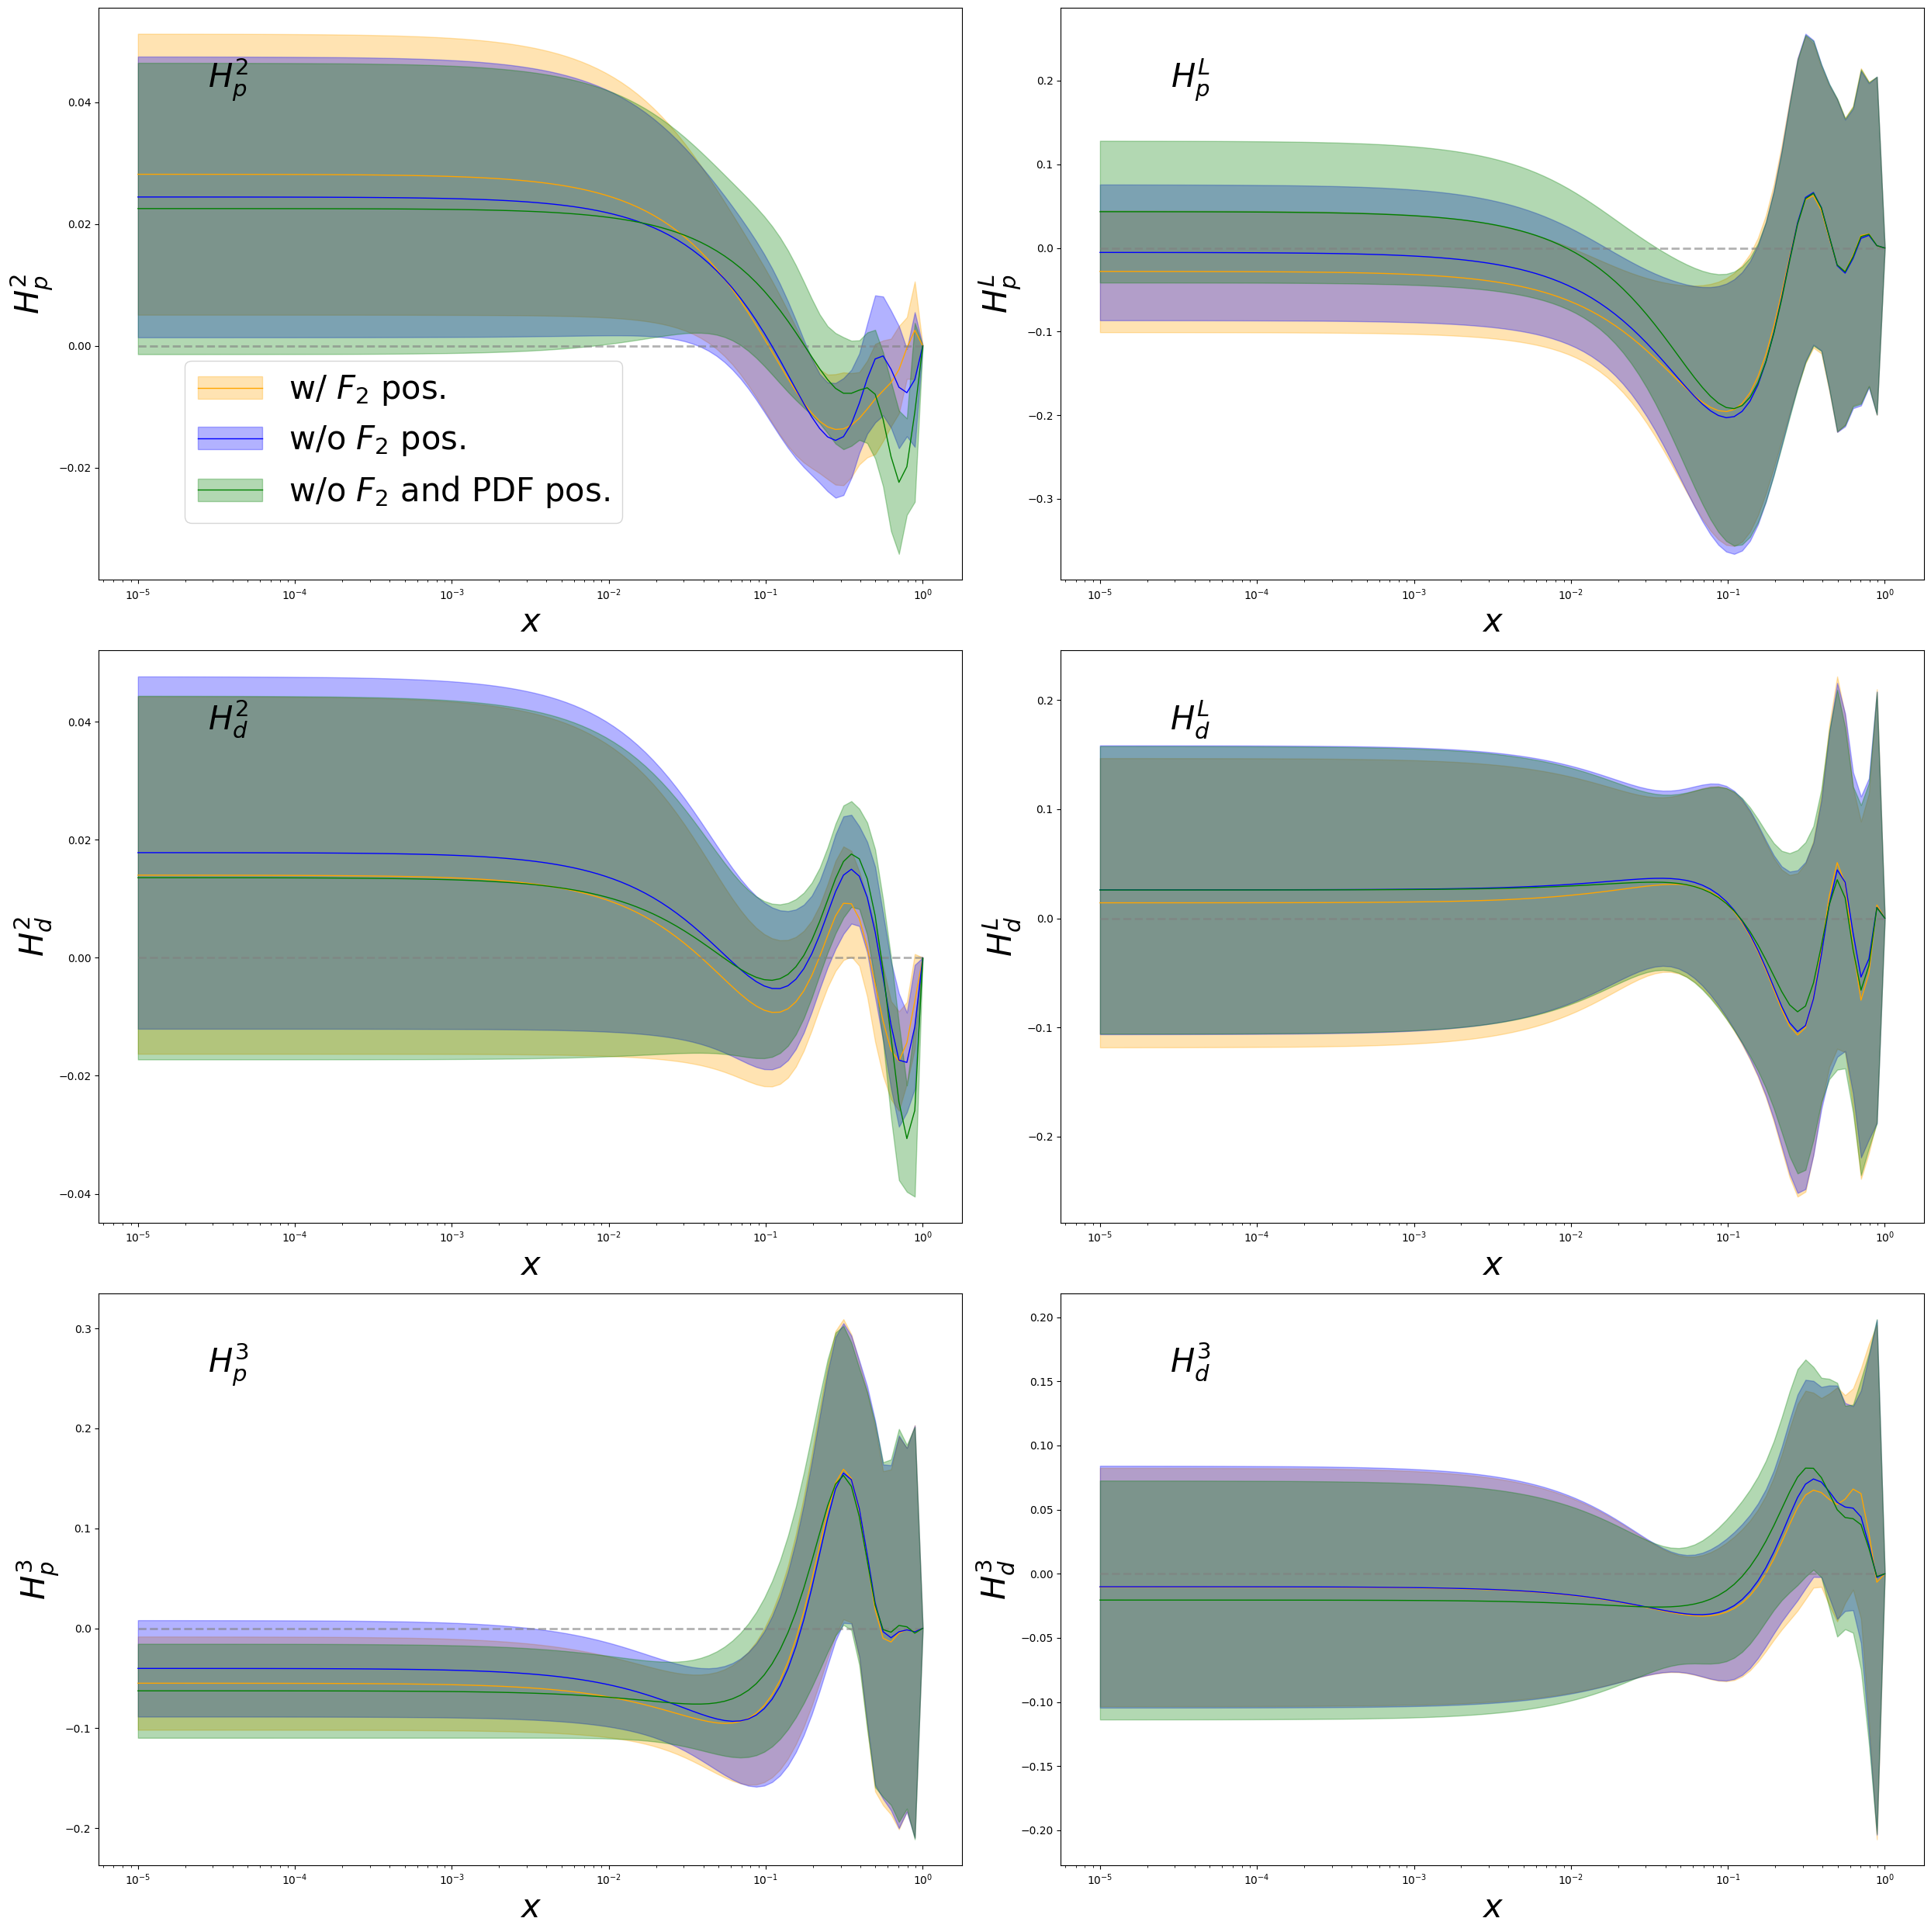

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
color = 'lightblue'
legends = []
legend_names = []
colors = ["orange", "blue", "green"]

xv = np.logspace(-5, -0.0001, 100)

for idx_set, (setname, HT_set) in enumerate(HT_sets.items()):
  for idx_ax, (ax, key) in enumerate(zip(axs.flatten(), ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d"])):
    htf = HT_set(xv, key)
    central = htf.mean(axis=1)
    std = htf.std(axis=1)

    #central_nodes = np.concatenate([HT_set.central_nodes.xs(level="HT", key=key).to_numpy(), [0]])
    #nodes = ax.plot(x_nodes[setname][key], central_nodes, 'o', label='data')
    pl = ax.plot(xv, central, ls = "-", lw = 1, color = colors[idx_set])
    pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
    pl_fb  = ax.fill_between(xv, central - std, central + std , color = pl[0].get_color(),  alpha = 0.3)
    # Zero line, only at first iteration
    if idx_set == 0:
      ax.plot(xv, np.zeros_like(xv), ls = "dashed", lw = 2, color="grey", alpha=0.6)
      ax.set_xscale("log")
      ax.set_xlabel(f'$x$', fontsize = 30)
      ax.set_ylabel(rf"$H^{key[1]}_{key[2]}$", fontsize = 30)
      ax.set_title(rf"$H^{key[1]}_{key[2]}$", x = 0.15, y=0.85, fontsize=30)

  legends.append((pl[0], pl_lg[0]))
  legend_names.append(fit_label[setname])
    #label = rf"$H^{key[1]}_{key[2]} \pm \sigma$ MC"
    #ax.legend([(pl[0], pl_lg[0])], [label, "nodes"], loc=[0.1, 0.1], fontsize=30)

axs[0,0].legend(legends, legend_names, loc=[0.1, 0.1], fontsize=30)

fig.tight_layout()
fig.savefig(save_dir + "/log_comparison.png")

In [6]:
for ax in axs.flatten():
  ax.set_xscale('linear')

fig.tight_layout()
fig.savefig(save_dir + "/linear_comparison.png")